# Fakeddit Data Analysis

This section displays the finding of a thorough data analysis of the `Fakeddit-Benchmark` dataset after *Nakamura et al. (2020)*. It is intended to provide an understanding for the decision making process in tuning and setting `hyperparameters`, defining model architecture as well as applied techniques and choosing input data for `DistilFND`and variants. In essence it gives an analytical insight into the `Fakeddit` dataset. Further, it provides an explanation and hands-on practices for preprocessing the input data of all modalities including post-title, images and comment data provided.

# Importing needed modules

In [2]:
#Importing needed modules
import os
import numpy as np
import keras
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Import widgets module
import ipywidgets as widgets
# Importing display function from IPython module
from IPython.display import display

# Analysis of data and token length distribution

### Fakeddit Data Distribution

Fakeddit dataset splits are extremely imbalanced, as can be seen by plotted graph below. During model training, testing and validation the dataset splits will be left unchanged. Because of the long duration of scraping data from Reddit (about 10 years) it is assumed, that the current class distribution represents real world data distribution regarding specific types of Fake News on social media. Thus, keeping an uneven data dsitribution might possibly yield attributes favorable for correct classification and model training.

In [4]:
# Method to read input data from tsv file into dataframe
def initialize_dataframe(path, file):
    dataframe = pd.read_csv(os.path.join(path, file), delimiter="\t")
    
    # If comment data loaded, clean column 'Unnamed: 0'
    if "Unnamed: 0" in dataframe.columns:
        dataframe = dataframe.drop(["Unnamed: 0"], 1)
        
    return dataframe

In [5]:
# Read input into dataframes
df_test = initialize_dataframe("dataset", "multimodal_test_public.tsv")
df_validate = initialize_dataframe("dataset", "multimodal_validate.tsv")
df_train = initialize_dataframe("dataset", "multimodal_train.tsv")

In [24]:
print("Training split contains: " + str(len(df_train)) + " samples")
print("Validate split contains: " + str(len(df_validate)) + " samples")
print("Test split contains: " + str(len(df_test)) + " samples")

Training split contains: 564000 samples
Validate split contains: 59342 samples
Test split contains: 59319 samples


In [11]:
def plot_data_distribution(dataframe):

    ax = sns.countplot(dataframe["6_way_label"])
    plt.xlabel("6 Way Classification");

    # Define class names per integer value: see https://github.com/entitize/Fakeddit/issues/14
    # for confirmation
    class_names = ["True\n(0)", "Satire\n(1)", "False Conn.\n(2)", "Impost. Content\n(3)",
                          "Man. Content\n(4)", "Mis. Content\n(5)"]
    
    # Set class names for x axis
    ax.set_xticklabels(class_names);

C:\ProgramData\Anaconda3\envs\FakeNewsDetector\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


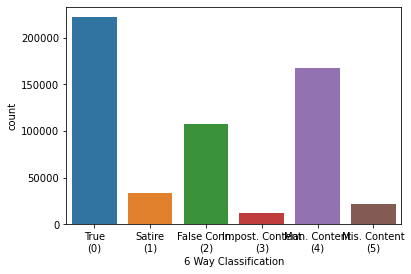

In [8]:
# PLotting subtype class distribution for complete training set
plot_data_distribution(df_train)

C:\ProgramData\Anaconda3\envs\FakeNewsDetector\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


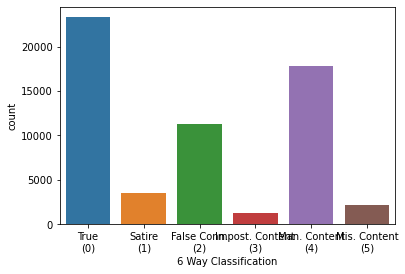

In [9]:
# PLotting subtype class distribution for complete validation set
plot_data_distribution(df_validate)

C:\ProgramData\Anaconda3\envs\FakeNewsDetector\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


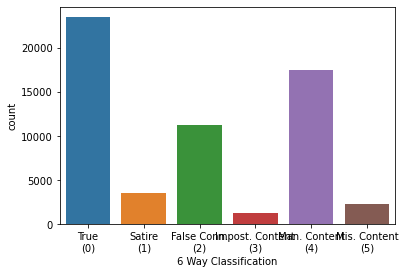

In [10]:
# PLotting subtype class distribution for complete test set
plot_data_distribution(df_test)

### Splitting complete Fakeddit dataset in training, validate and test splits

Apply `train_test_split()`function from Scikit-learn in order to minimize complete dataset
with over *700.000* samples. Splitting complete dataset into custom training, validate and test sets,
while reusing only *20%* of the original data (*80%* for training and *10%* for validation and testing each). 
Stratify function is applied in order to keep the
per class sample distribution from original Fakeddit source dataset.

In [6]:
# Splitting complete Fakeddit-dataset into 20% training dataframe
# and 80% backup dataframe
df_train_split, df_backup = train_test_split(
    df_train,
    test_size=0.8,
    shuffle=True,
    # Apply stratification on basis of 6 way label classification
    # maintaining percentage of samples per class as given by original dataset
    stratify=df_train["6_way_label"]
)

In [7]:
# Keeping 80% of data samples for training and 20% for testing purposes
df_train_split, df_test_split = train_test_split(
    df_train,
    test_size=0.2,
    shuffle=True,
    # Apply stratification on basis of 6 way label classification
    # maintaining percentage of samples per class as given by original dataset
    stratify=df_train["6_way_label"]
)

In [8]:
# Dividing test split dataframe by factor 0,5 to have identically
# sized splits for validation and testing
df_test_split, df_validate_split = train_test_split(
    df_test,
    test_size=0.5,
    shuffle=True,
    # Apply stratification on basis of 6 way label classification
    # maintaining percentage of samples per class as given by original dataset
    stratify=df_test["6_way_label"]
)

In [9]:
# Number of samples contained in each of the splits
print("Training split contains: " + str(len(df_train_split)) + " samples")
print("Validate split contains: " + str(len(df_validate_split)) + " samples")
print("Test split contains: " + str(len(df_test_split)) + " samples")

Training split contains: 451200 samples
Validate split contains: 29660 samples
Test split contains: 29659 samples


Stratifying keeps the percentage sample distribution per fake news subtype class. The complete splits are downsamples to only *20%* of the original data, yet the **class distribution is maintained in each of the splits**.

C:\ProgramData\Anaconda3\envs\FakeNewsDetector\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


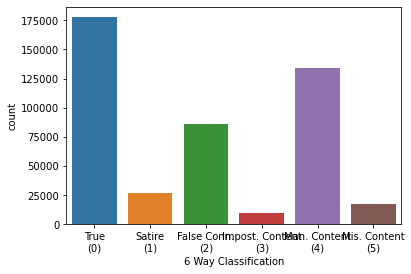

In [12]:
# PLotting subtype class distribution for downsized training set split
plot_data_distribution(df_train_split)

C:\ProgramData\Anaconda3\envs\FakeNewsDetector\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


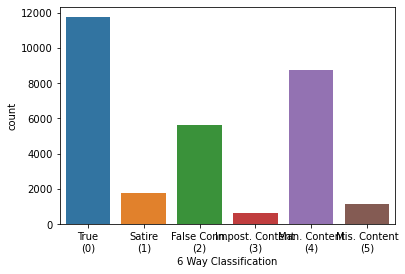

In [13]:
# PLotting subtype class distribution for downsized validate set split
plot_data_distribution(df_validate_split)

C:\ProgramData\Anaconda3\envs\FakeNewsDetector\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


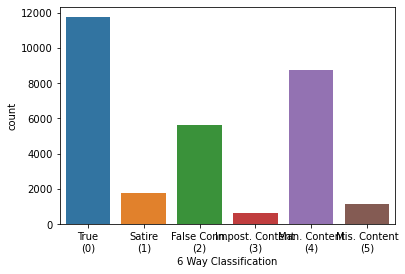

In [14]:
# PLotting subtype class distribution for downsized test set split
plot_data_distribution(df_test_split)

### Post-Title token length analysis

Discovered is extreme density in short post title size **between 0 and 30 tokens**. Intuitively expected as text titles in posts on social media platform Reddit are usually kept very short, comparable to Twitter. To be on the safe side, **maximum length of 80 is chosen for sequence length**.

In [4]:
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

In [16]:
def plot_token_distribution(dataframe):

    token_length = []

    # Iteration over given dataframe and count of tokens for every
    # post sample
    for post in tqdm(dataframe["clean_title"]):
        tokens = tokenizer.encode(post)
        token_length.append(len(tokens))

    # Plotting post sample token counts with distribution plot
    sns.distplot(token_length)
    plt.xlim([0, 60])
    plt.xlabel("Token Count")

<ipython-input-16-c03fa2ab99bd>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for post in tqdm(dataframe["clean_title"]):


  0%|          | 0/564000 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (614 > 512). Running this sequence through the model will result in indexing errors
C:\ProgramData\Anaconda3\envs\FakeNewsDetector\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


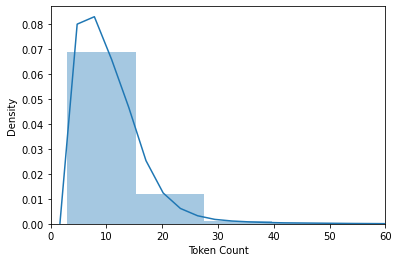

In [17]:
# Plotting token length distribution for complete training set
plot_token_distribution(df_train)

<ipython-input-16-c03fa2ab99bd>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for post in tqdm(dataframe["clean_title"]):


  0%|          | 0/59342 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\envs\FakeNewsDetector\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


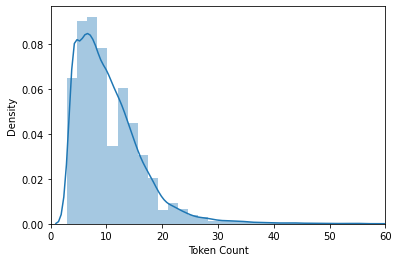

In [18]:
# Plotting token length distribution for complete validation set
plot_token_distribution(df_validate)

<ipython-input-16-c03fa2ab99bd>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for post in tqdm(dataframe["clean_title"]):


  0%|          | 0/59319 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\envs\FakeNewsDetector\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


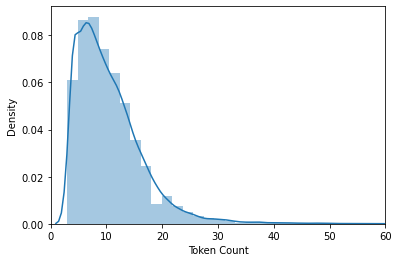

In [19]:
# Plotting token length distribution for complete test set
plot_token_distribution(df_test)

### Analysis of information per sample

To develop an understanding for Fakeddit dataset and the in **total 16 contained information/attributes per Reddit-Post sample**, for each complete data set (training, validation and test) the composition of attributes including the total count of available attributes is presented via the `dataframe.info()` function below. Further, the **first 5 rows of every dataframe** containing the complete training, validation and test sets is displayed below via the `dataframe.head()` function.

In [20]:
# Display info about contained attributes/information per Reddit-Post for training set
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564000 entries, 0 to 563999
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   author                535290 non-null  object 
 1   clean_title           564000 non-null  object 
 2   created_utc           564000 non-null  float64
 3   domain                396143 non-null  object 
 4   hasImage              564000 non-null  bool   
 5   id                    564000 non-null  object 
 6   image_url             562466 non-null  object 
 7   linked_submission_id  167857 non-null  object 
 8   num_comments          396143 non-null  float64
 9   score                 564000 non-null  int64  
 10  subreddit             564000 non-null  object 
 11  title                 564000 non-null  object 
 12  upvote_ratio          396143 non-null  float64
 13  2_way_label           564000 non-null  int64  
 14  3_way_label           564000 non-null  int64  
 15  

In [21]:
# Display first 5 rows of complete training set
df_train.head()

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
0,Alexithymia,my walgreens offbrand mucinex was engraved wit...,1.551641e+09,i.imgur.com,True,awxhir,https://external-preview.redd.it/WylDbZrnbvZdB...,NaN,2.0,12,mildlyinteresting,My Walgreens offbrand Mucinex was engraved wit...,0.84,1,0,0
1,VIDCAs17,this concerned sink with a tiny hat,1.534727e+09,i.redd.it,True,98pbid,https://preview.redd.it/wsfx0gp0f5h11.jpg?widt...,NaN,2.0,119,pareidolia,This concerned sink with a tiny hat,0.99,0,2,2
2,prometheus1123,hackers leak emails from uae ambassador to us,1.496511e+09,aljazeera.com,True,6f2cy5,https://external-preview.redd.it/6fNhdbc6K1vFA...,NaN,1.0,44,neutralnews,Hackers leak emails from UAE ambassador to US,0.92,1,0,0
3,NaN,puppy taking in the view,1.471341e+09,i.imgur.com,True,4xypkv,https://external-preview.redd.it/HLtVNhTR6wtYt...,NaN,26.0,250,photoshopbattles,PsBattle: Puppy taking in the view,0.95,1,0,0
4,3rikR3ith,i found a face in my sheet music too,1.525318e+09,i.redd.it,True,8gnet9,https://preview.redd.it/ri7ut2wn8kv01.jpg?widt...,NaN,2.0,13,pareidolia,I found a face in my sheet music too!,0.84,0,2,2


In [22]:
# Display info about contained attributes/information per Reddit-Post for validation set
df_validate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59342 entries, 0 to 59341
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   author                56279 non-null  object 
 1   clean_title           59342 non-null  object 
 2   created_utc           59342 non-null  float64
 3   domain                41532 non-null  object 
 4   hasImage              59342 non-null  bool   
 5   id                    59342 non-null  object 
 6   image_url             59169 non-null  object 
 7   linked_submission_id  17810 non-null  object 
 8   num_comments          41532 non-null  float64
 9   score                 59342 non-null  int64  
 10  subreddit             59342 non-null  object 
 11  title                 59342 non-null  object 
 12  upvote_ratio          41532 non-null  float64
 13  2_way_label           59342 non-null  int64  
 14  3_way_label           59342 non-null  int64  
 15  6_way_label        

In [23]:
# Display first 5 rows of complete validation set
df_validate.head()

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
0,singingdart7854,my xbox controller says hi,1.567436e+09,i.redd.it,True,cypw96,https://preview.redd.it/l0ga0tug17k31.jpg?widt...,NaN,4.0,25,mildlyinteresting,My Xbox controller says hi,0.72,1,0,0
1,mandal0re,new image from the mandalorian,1.567745e+09,i.imgur.com,True,d0bzlq,https://external-preview.redd.it/VX7bXDu9Gl8UZ...,NaN,5.0,21,photoshopbattles,PsBattle: New image from The Mandalorian,0.92,1,0,0
2,HE_WHO_DRUELS,say hello to my little friend,1.461468e+09,NaN,True,d2ezoob,http://i.imgur.com/F1Zbl3D.jpg,4g6bp9,NaN,10,psbattle_artwork,Say hello to my little friend!,NaN,0,2,4
3,eNaRDe,watch your step little one,1.408047e+09,NaN,True,cjqctpw,http://i.imgur.com/KRyMjn1.jpg,2diyh3,NaN,1,psbattle_artwork,Watch your step little one,NaN,0,2,4
4,Thebubster2001,this tree i found with a solo cup on it,1.558186e+09,i.redd.it,True,bq3yuk,https://preview.redd.it/bxp58zf01zy21.jpg?widt...,NaN,8.0,6,mildlyinteresting,This tree I found with a solo cup on it,0.62,1,0,0


In [24]:
# Display info about contained attributes/information per Reddit-Post for test set
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59319 entries, 0 to 59318
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   author                56251 non-null  object 
 1   clean_title           59319 non-null  object 
 2   created_utc           59319 non-null  float64
 3   domain                41847 non-null  object 
 4   hasImage              59319 non-null  bool   
 5   id                    59319 non-null  object 
 6   image_url             59163 non-null  object 
 7   linked_submission_id  17472 non-null  object 
 8   num_comments          41847 non-null  float64
 9   score                 59319 non-null  int64  
 10  subreddit             59319 non-null  object 
 11  title                 59319 non-null  object 
 12  upvote_ratio          41847 non-null  float64
 13  2_way_label           59319 non-null  int64  
 14  3_way_label           59319 non-null  int64  
 15  6_way_label        

In [25]:
# Display first 5 rows of complete test set
df_test.head()

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
0,trustbytrust,stargazer,1.425139e+09,NaN,True,cozywbv,http://i.imgur.com/BruWKDi.jpg,2xct9d,NaN,3,psbattle_artwork,stargazer,NaN,0,2,4
1,NaN,yeah,1.438173e+09,NaN,True,ctk61yw,http://i.imgur.com/JRZT727.jpg,3f0h7o,NaN,2,psbattle_artwork,yeah,NaN,0,2,4
2,chaseoes,pd phoenix car thief gets instructions from yo...,1.560492e+09,abc15.com,True,c0gl7r,https://external-preview.redd.it/1A2_4VwgS8Qd2...,NaN,2.0,16,nottheonion,PD: Phoenix car thief gets instructions from Y...,0.89,1,0,0
3,SFepicure,as trump accuses iran he has one problem his o...,1.560606e+09,nytimes.com,True,c0xdqy,https://external-preview.redd.it/9BKRcgvaobpTo...,NaN,4.0,45,neutralnews,"As Trump Accuses Iran, He Has One Problem: His...",0.78,1,0,0
4,fragments_from_Work,believers hezbollah,1.515139e+09,i.imgur.com,True,7o9rmx,https://external-preview.redd.it/rbwXHncnjVh51...,NaN,40.0,285,propagandaposters,"""Believers"" - Hezbollah 2011",0.95,0,1,5


### Analysis of sample count per class

Counting the number of samples per subtype/class of contained fake news, authentic content and satire/parody samples. This information is needed, in order to adapt the weighted `CrossEntropyLoss` function for an adjusted loss calculation dependent of the prevalence of each individual class.

In [26]:
# Counting the samples per class/subtype for complete training set
label_count = [df_train["6_way_label"].value_counts().sort_index(0)[0],
               df_train["6_way_label"].value_counts().sort_index(0)[1],
               df_train["6_way_label"].value_counts().sort_index(0)[2],
               df_train["6_way_label"].value_counts().sort_index(0)[3],
               df_train["6_way_label"].value_counts().sort_index(0)[4],
               df_train["6_way_label"].value_counts().sort_index(0)[5]]

print(label_count)

[222081, 33481, 107221, 11784, 167857, 21576]


<ipython-input-26-534ac3dbd7a0>:1: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only
  label_count = [df_train["6_way_label"].value_counts().sort_index(0)[0],
<ipython-input-26-534ac3dbd7a0>:2: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only
  df_train["6_way_label"].value_counts().sort_index(0)[1],
<ipython-input-26-534ac3dbd7a0>:3: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only
  df_train["6_way_label"].value_counts().sort_index(0)[2],
<ipython-input-26-534ac3dbd7a0>:4: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only
  df_train["6_way_label"].value_counts().sort_index(0)[3],
<ipython-input-26-534ac3dbd7a0>:5: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only
  df_train["6_way_label"].value_counts().sort_index(0)[4],
<ipython-i

In [22]:
# Counting the samples per class/subtype for complete training set
label_count = [df_validate["6_way_label"].value_counts().sort_index(0)[0],
               df_validate["6_way_label"].value_counts().sort_index(0)[1],
               df_validate["6_way_label"].value_counts().sort_index(0)[2],
               df_validate["6_way_label"].value_counts().sort_index(0)[3],
               df_validate["6_way_label"].value_counts().sort_index(0)[4],
               df_validate["6_way_label"].value_counts().sort_index(0)[5]]

print(label_count)

[23320, 3521, 11277, 1238, 17810, 2176]


<ipython-input-22-eedfcc3ba1fd>:1: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only
  label_count = [df_validate["6_way_label"].value_counts().sort_index(0)[0],
<ipython-input-22-eedfcc3ba1fd>:2: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only
  df_validate["6_way_label"].value_counts().sort_index(0)[1],
<ipython-input-22-eedfcc3ba1fd>:3: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only
  df_validate["6_way_label"].value_counts().sort_index(0)[2],
<ipython-input-22-eedfcc3ba1fd>:4: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only
  df_validate["6_way_label"].value_counts().sort_index(0)[3],
<ipython-input-22-eedfcc3ba1fd>:5: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only
  df_validate["6_way_label"].value_counts().sort_index(0)

In [23]:
# Counting the samples per class/subtype for complete training set
label_count = [df_test["6_way_label"].value_counts().sort_index(0)[0],
               df_test["6_way_label"].value_counts().sort_index(0)[1],
               df_test["6_way_label"].value_counts().sort_index(0)[2],
               df_test["6_way_label"].value_counts().sort_index(0)[3],
               df_test["6_way_label"].value_counts().sort_index(0)[4],
               df_test["6_way_label"].value_counts().sort_index(0)[5]]

print(label_count)

[23507, 3514, 11297, 1224, 17472, 2305]


<ipython-input-23-31b0837141ed>:1: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only
  label_count = [df_test["6_way_label"].value_counts().sort_index(0)[0],
<ipython-input-23-31b0837141ed>:2: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only
  df_test["6_way_label"].value_counts().sort_index(0)[1],
<ipython-input-23-31b0837141ed>:3: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only
  df_test["6_way_label"].value_counts().sort_index(0)[2],
<ipython-input-23-31b0837141ed>:4: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only
  df_test["6_way_label"].value_counts().sort_index(0)[3],
<ipython-input-23-31b0837141ed>:5: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only
  df_test["6_way_label"].value_counts().sort_index(0)[4],
<ipython-input-

# Example of DistilBert Post-Title tokenization process

Following a tokenization process example is displayed by tokenizing a sample Reddit Post-Title via the DistilBert tokenizer pre-trained on the lower cased `English Wikipedia`  and `Toronto Book Corpus`. The encoded `input_ids` and `attention_mask` of the post title are then fed to the pre-trained `DistilBert` model during training and prediction processes. However, down below the tokenized and encoded input sequence is decoded in the final step for the purpose of comparison and better understanding. Also, the special tokens `[CLS]` for an aggregated representation of the classification decision for the input sequence, the `[SEP]`token, which separating the input sequence and the `[PAD]`token for right-side passing and converting the input sequences to identical token lengths, become visible.

In [21]:
# Load needed DistilBert tokenizer
from transformers import DistilBertTokenizer

# Assign tokenizer with pretrained language understanding of lower cased English text corpus
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

In [5]:
# Display original post title text input sequence
print("Post Titel:", end=" ")
post_title = df_test["clean_title"][3]
print(post_title)
print()
print()

# Tokenize post tile and display tokenized sequence
print("Tokens:", end=" ")
tokens = tokenizer.tokenize(post_title)
for i in range(len(tokens)):
    print(tokens[i], end=" ")

print()
print()
print()

# Convert token sequence into sequence of numeric values / representations
print("Token ID:", end=" ")
token_ids = tokenizer.convert_tokens_to_ids(tokens)
for i in range(len(token_ids)):
    print(token_ids[i], end=" ")

print()
print()
print()

# Encode tokenized numeric value sequence
encoding = tokenizer.encode_plus(
            post_title,
            max_length=80,
            padding="max_length",
            truncation=True,
            add_special_tokens=True,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors="pt",
        )

# Display encoded post-title input_ids (input for DistilBert)
print("Encoded Input ID:", end=" ")
for i in range(0, 15):
    print(encoding["input_ids"][0][i].item(), end=" ")

print()
print()
print()

# Display encoded post-title attention_mask (input for DistilBert)
print("Encoded Attention Mask:", end=" ")
for i in range(0, 15):
    print(encoding["attention_mask"][0][i].item(), end=" ")

print()
print()
print()

# Display decoded input token sequence to convert sequence back to readable tokens
# Additionally, the special tokens [CLS], [SEP] and [PAD] become visible
encoding_tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"][0].flatten())

print("Decoded Zeichen / Token:", end=" ")
for i in range(len(encoding_tokens)):
    if i == 15:
        break
    print(encoding_tokens[i], end=" ")

Post Titel: as trump accuses iran he has one problem his own credibility


Zeichen / Tokens: as trump accuse ##s iran he has one problem his own credibility 


Zeichen / Token ID: 2004 8398 26960 2015 4238 2002 2038 2028 3291 2010 2219 21553 


Enkodierte Input ID: 101 2004 8398 26960 2015 4238 2002 2038 2028 3291 2010 2219 21553 102 0 


Enkodierte Attention Mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 


Dekodierte Zeichen / Token: [CLS] as trump accuse ##s iran he has one problem his own credibility [SEP] [PAD] 

# Analysis Reddit Comment Data

In this section, the data analysis and preprocessing steps for the Reddit comment data is displayed and explained. The complete comment data `tsv-file` contains a total of over **10 Million* data entries** and leads to a combined file size of approx. **1,87GB**. In order to reduce the file size for better data handling and loading. In order to reducing the inference / model training times, all comment data entries were preprocessed before model training. Essentially, an iteration over all post samples contained in training, validation and test set was conducted. A second iteration then processed the complete comments data file and identified associated comments via the `post id`, whereas `post id` in training, validation and test data sets equal the `submission_id`of entries in comment set. During this procedure for every Reddit post the **first 5 comments** were concatenated into one `String sequence` and implemented into a new `coomments` column within a copy of the original data split `pandas` dataframe. The resulting dataframe was then saved into separate `tsv-files` yielding to a `multimodal_train_comments.tsv`, `multimodal_validate_comments.tsv` and `multimodal_test_comments.tsv`, which contain the **original 16 attributes per row / post** and an **additional 17th column containing the first 5 comments per post**. If no comments could be found, an empty `String sequence`was implemented.

In [15]:
# Reading in all comment data
df_comments = initialize_dataframe("dataset", "all_comments.tsv")

<ipython-input-15-65c7f8439788>:2: DtypeWarning: Columns (0,1,2,3,4,5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  df_comments = initialize_dataframe("dataset", "all_comments.tsv")
<ipython-input-4-def61c4fb30b>:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  dataframe = dataframe.drop(["Unnamed: 0"], 1)


In [19]:
# Display total number of comment data entries in complete comment tsv-file
print("Comment data contains: " + str(len(df_comments)) + " entries.")

Comment data contains: 10697533 entries.


In [16]:
# Display information / attributes (columns) for comments dataframe
df_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10697533 entries, 0 to 10697532
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   id             object 
 1   author         object 
 2   body           object 
 3   isTopLevel     object 
 4   parent_id      object 
 5   submission_id  object 
 6   ups            float64
dtypes: float64(1), object(6)
memory usage: 571.3+ MB


In [17]:
-# Display first 5 rows of comments dataframe
df_comments.head()

,id,author,body,isTopLevel,parent_id,submission_id,ups
0,f4deplg,Haus42,"Scroll, scroll, scroll. Pause. Scroll back u...",True,t3_dkdml1,dkdml1,162.0
1,f4d79bi,PotatoPrince84,A lot of the people who felt quite strongly ab...,True,t3_dkdml1,dkdml1,84.0
2,f4ddmlk,MadeToAchieveBalance,T H E S P H E R E S H A L L R I S E A ...,True,t3_dkdml1,dkdml1,34.0
3,f4dknfn,MrBigRed,All hail the cube of justice,True,t3_dkdml1,dkdml1,9.0
4,f4dgdur,burritosenior,That is glorious.,True,t3_dkdml1,dkdml1,4.0


In [18]:
# The associated comments of an original Reddit-Post are linked via
# the (post) id (in respective data set splits) eualling the submission_id in comments data set
df_train.loc[df_train["id"] == df_comments["submission_id"][0]]

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
142277,AlexPosts17,mark zuckerberg announces all of facebooks fut...,1.571538e+09,theonion.com,True,dkdml1,https://external-preview.redd.it/k3I7j91YmjXdM...,NaN,15.0,1491,theonion,Mark Zuckerberg Announces All Of Facebook’s Fu...,0.99,0,2,1


In [ ]:
# Iterate through initial train, test, validate splits and retrieve/process comment data from comment tsv file
def process_comment_data(df_input, df_comment_data, filename):
    
    # Limit resulting comment text sequence to 2048 tokens
    length = 2048

    # Iterate over original post data set (df_train, df_validate, df_test)
    # using the (post) id as a discriminator
    for id in tqdm(df_input["id"]):
        
        # List to append found comments to
        post_comments = []
        # Find corresponding comments via comparison of (post) id to submission_id in comment data
        df_per_post = df_comment_data.loc[df_comment_data["submission_id"] == str(id)]
        
        # If no comments assigned to specific post, assign empty string
        if len(df_per_post) == 0:
            df_input.loc[df_input.loc[df_input["id"] == str(id)].index[0], "comments"] = ""
        else:
            try:
                #Iterate over all found comments --> Handling different indices and iteration counts
                for i in range(df_per_post.index[0], df_per_post.index[0] + len(df_per_post)):
                    # If comment deleted, then skip
                    if df_per_post["body"][i] == "[deleted]":
                        continue
                    # If comment removed, then skip
                    elif df_per_post["body"][i] == "[removed]":
                        continue
                    else:
                        # If true comment found, append to corresponding comment list
                        comment = str(df_per_post["body"][i])
                        post_comments.append(comment)
            # If indices do not match, assign empty string
            # Usually indicated one single comment by moderator regarding
            # general insignificant instruction for subbreddit conduct guidelines
            except KeyError:
                comment = ""
                post_comments.append(comment)
        
        # If no cases apply, empty string
        if not post_comments:
            post_comments.append("")
        
        # Concatenate only first 5 found comments
        comments = " ".join(post_comments[:5])
        # If comments exceed given length limit, slice list
        comments = (comments[:length]) if len(comments) > length else comments
        
        # Implement found comments per post in 17th column of post dataframe
        df_input.loc[df_input.loc[df_input["id"] == str(id)].index[0], "comments"] = comments
    
    # Writing df_input split including comments column to tsv file
    print("Writing comment data split to csv file.")
    df_input.to_csv(f"data/{filename}", sep="\t", mode="a", index=True, header=False)

In [ ]:
%%time
# Process comment data for post training data set and write results to corresponding tsv-file
process_comment_data(df_train, df_comments, "multimodal_train_comments.tsv")

In [ ]:
%%time
# Process comment data for post validation data set and write results to corresponding tsv-file
process_comment_data(df_test, df_comments, "multimodal_validate_comments.tsv")

In [ ]:
%%time
# Process comment data for post test data set and write results to corresponding tsv-file
process_comment_data(df_test, df_comments, "multimodal_test_comments.tsv")

After completion of the comment processing steps, the newly created data split dataframes can be loaded including the additional 17th comments column.

In [6]:
# Read input into dataframes
df_test = initialize_dataframe("dataset", "multimodal_test_comments.tsv")
df_validate = initialize_dataframe("dataset", "multimodal_validate_comments.tsv")
df_train = initialize_dataframe("dataset", "multimodal_train_comments.tsv")

<ipython-input-2-def61c4fb30b>:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  dataframe = dataframe.drop(["Unnamed: 0"], 1)


In [30]:
# Display information/attributes of training set dataframe including comments column
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564000 entries, 0 to 563999
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   author                535290 non-null  object 
 1   clean_title           564000 non-null  object 
 2   created_utc           564000 non-null  float64
 3   domain                396143 non-null  object 
 4   hasImage              564000 non-null  bool   
 5   id                    564000 non-null  object 
 6   image_url             562466 non-null  object 
 7   linked_submission_id  167857 non-null  object 
 8   num_comments          396143 non-null  float64
 9   score                 564000 non-null  int64  
 10  subreddit             564000 non-null  object 
 11  title                 564000 non-null  object 
 12  upvote_ratio          396143 non-null  float64
 13  2_way_label           564000 non-null  int64  
 14  3_way_label           564000 non-null  int64  
 15  

In [31]:
# Display first 5 rows of training set dataframe including comments column
df_train.head()

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label,comments
0,Alexithymia,my walgreens offbrand mucinex was engraved wit...,1.551641e+09,i.imgur.com,True,awxhir,https://external-preview.redd.it/WylDbZrnbvZdB...,NaN,2.0,12,mildlyinteresting,My Walgreens offbrand Mucinex was engraved wit...,0.84,1,0,0,Does it help with Dyslexia? Pretty sure it mak...
1,VIDCAs17,this concerned sink with a tiny hat,1.534727e+09,i.redd.it,True,98pbid,https://preview.redd.it/wsfx0gp0f5h11.jpg?widt...,NaN,2.0,119,pareidolia,This concerned sink with a tiny hat,0.99,0,2,2,“Does this hat make my head look too big?” -too
2,prometheus1123,hackers leak emails from uae ambassador to us,1.496511e+09,aljazeera.com,True,6f2cy5,https://external-preview.redd.it/6fNhdbc6K1vFA...,NaN,1.0,44,neutralnews,Hackers leak emails from UAE ambassador to US,0.92,1,0,0,---- **/r/NeutralNews is a curated space.**\nI...
3,NaN,puppy taking in the view,1.471341e+09,i.imgur.com,True,4xypkv,https://external-preview.redd.it/HLtVNhTR6wtYt...,NaN,26.0,250,photoshopbattles,PsBattle: Puppy taking in the view,0.95,1,0,0,[EVERYTHING THE LIGHT TOUCHES IS OUR KINGDOM](...
4,3rikR3ith,i found a face in my sheet music too,1.525318e+09,i.redd.it,True,8gnet9,https://preview.redd.it/ri7ut2wn8kv01.jpg?widt...,NaN,2.0,13,pareidolia,I found a face in my sheet music too!,0.84,0,2,2,That crescendo part at the top also kind of lo...


In [32]:
# Display information/attributes of validation set dataframe including comments column
df_validate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59342 entries, 0 to 59341
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   author                56279 non-null  object 
 1   clean_title           59342 non-null  object 
 2   created_utc           59342 non-null  float64
 3   domain                41532 non-null  object 
 4   hasImage              59342 non-null  bool   
 5   id                    59342 non-null  object 
 6   image_url             59169 non-null  object 
 7   linked_submission_id  17810 non-null  object 
 8   num_comments          41532 non-null  float64
 9   score                 59342 non-null  int64  
 10  subreddit             59342 non-null  object 
 11  title                 59342 non-null  object 
 12  upvote_ratio          41532 non-null  float64
 13  2_way_label           59342 non-null  int64  
 14  3_way_label           59342 non-null  int64  
 15  6_way_label        

In [33]:
# Display first 5 rows of validation set dataframe including comments column
df_validate.head()

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label,comments
0,singingdart7854,my xbox controller says hi,1.567436e+09,i.redd.it,True,cypw96,https://preview.redd.it/l0ga0tug17k31.jpg?widt...,NaN,4.0,25,mildlyinteresting,My Xbox controller says hi,0.72,1,0,0,Actually it says Hello* They all do More like ...
1,mandal0re,new image from the mandalorian,1.567745e+09,i.imgur.com,True,d0bzlq,https://external-preview.redd.it/VX7bXDu9Gl8UZ...,NaN,5.0,21,photoshopbattles,PsBattle: New image from The Mandalorian,0.92,1,0,0,https://i.imgur.com/VrBLAip.jpg https://i.imgu...
2,HE_WHO_DRUELS,say hello to my little friend,1.461468e+09,NaN,True,d2ezoob,http://i.imgur.com/F1Zbl3D.jpg,4g6bp9,NaN,10,psbattle_artwork,Say hello to my little friend!,NaN,0,2,4,NaN
3,eNaRDe,watch your step little one,1.408047e+09,NaN,True,cjqctpw,http://i.imgur.com/KRyMjn1.jpg,2diyh3,NaN,1,psbattle_artwork,Watch your step little one,NaN,0,2,4,NaN
4,Thebubster2001,this tree i found with a solo cup on it,1.558186e+09,i.redd.it,True,bq3yuk,https://preview.redd.it/bxp58zf01zy21.jpg?widt...,NaN,8.0,6,mildlyinteresting,This tree I found with a solo cup on it,0.62,1,0,0,that's a telephone...disconnected Looks like t...


In [34]:
# Display information/attributes of test set dataframe including comments column
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59319 entries, 0 to 59318
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   author                56251 non-null  object 
 1   clean_title           59319 non-null  object 
 2   created_utc           59319 non-null  float64
 3   domain                41847 non-null  object 
 4   hasImage              59319 non-null  bool   
 5   id                    59319 non-null  object 
 6   image_url             59163 non-null  object 
 7   linked_submission_id  17472 non-null  object 
 8   num_comments          41847 non-null  float64
 9   score                 59319 non-null  int64  
 10  subreddit             59319 non-null  object 
 11  title                 59319 non-null  object 
 12  upvote_ratio          41847 non-null  float64
 13  2_way_label           59319 non-null  int64  
 14  3_way_label           59319 non-null  int64  
 15  6_way_label        

In [35]:
# Display first 5 rows of test set dataframe including comments column
df_test.head()

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label,comments
0,trustbytrust,stargazer,1.425139e+09,NaN,True,cozywbv,http://i.imgur.com/BruWKDi.jpg,2xct9d,NaN,3,psbattle_artwork,stargazer,NaN,0,2,4,NaN
1,NaN,yeah,1.438173e+09,NaN,True,ctk61yw,http://i.imgur.com/JRZT727.jpg,3f0h7o,NaN,2,psbattle_artwork,yeah,NaN,0,2,4,NaN
2,chaseoes,pd phoenix car thief gets instructions from yo...,1.560492e+09,abc15.com,True,c0gl7r,https://external-preview.redd.it/1A2_4VwgS8Qd2...,NaN,2.0,16,nottheonion,PD: Phoenix car thief gets instructions from Y...,0.89,1,0,0,> Police say they found a phone playing a YouT...
3,SFepicure,as trump accuses iran he has one problem his o...,1.560606e+09,nytimes.com,True,c0xdqy,https://external-preview.redd.it/9BKRcgvaobpTo...,NaN,4.0,45,neutralnews,"As Trump Accuses Iran, He Has One Problem: His...",0.78,1,0,0,---- **/r/NeutralNews is a curated space.**\nI...
4,fragments_from_Work,believers hezbollah,1.515139e+09,i.imgur.com,True,7o9rmx,https://external-preview.redd.it/rbwXHncnjVh51...,NaN,40.0,285,propagandaposters,"""Believers"" - Hezbollah 2011",0.95,0,1,5,Does Hezbollah actually have kit that nice? Ke...


# Processing Reddit-Image data

Post-Images are fetched in similar fashion as associated comments. The `post_id`is used to fetch corresponding images from the image set folder. Before feeding the images to the pre-trained `ResNet34` model, which is trained on the `ImageNet 2021 Benchmark-Dataset` and can classify objects on images into a total of 1000 different classes, they are being processed by the `train_transform()` function for the training split and by the `val_transform()` function for the validation and test splits. Reason being, that random cropping and random horizontal flipping implements `Data augmentation`by artificially inflating the underlying data set. For humans it is easily recognizable that a mirrored image of an already seen image, displays the identical content. For a computer system this is not so obvious. The model architecture of `ResNet34`and the in-between results of the processing steps for converting the images to input feature tensors is displayed below.

In [7]:
# Importing needed modules
import torch
import torch.nn as nn
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt

In [9]:
# Initializing ResNet34 model after He et al. (2015) with pre-trained weights on ImageNet dataset
image_module = models.resnet34(pretrained="imagenet")

In [10]:
# Fully connected layer to map the 1000 out-features of last ResNet-layer on the 6 defined classes
num_classes = 6
image_module.fc = nn.Linear(in_features=1000, out_features=num_classes, bias=True)

In [11]:
# Display model architecture of ResNet34
print(image_module)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
# train_transform with data augmentation for training split,
# and val_transform without data augmentation for validation and test splits
from torchvision import transforms

# Data augmentation and normalization for training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224), # random resizing -> data augmentation
    transforms.RandomHorizontalFlip(), # random flipping -> data augmentation
    transforms.ToTensor(),             # converting image data to tensor           
    transforms.Normalize(              # normalizing image tensor
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.255]
    )
])

# Just normalization for validation
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.255]
    )
])

In [15]:
# Loading original image from image folder
image = Image.open("dataset/image_set/cozywbv.jpg")

# Transforming it for training and validation/test purposes
image_train = train_transform(image)
image_val = val_transform(image)

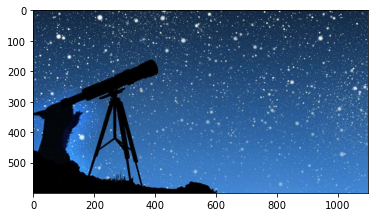

In [20]:
# Display original image of post sample
%matplotlib inline
plt.imshow(image)
plt.show()

In [16]:
# Display tensor representation of loaded image for training split
print(image_train)

tensor([[[-1.6042, -1.7240, -1.6042,  ..., -1.4843, -1.7069, -1.6727],
         [-1.5357, -1.6384, -1.7069,  ..., -1.5357, -1.5357, -0.6623],
         [-1.5357, -1.6384, -1.7069,  ..., -1.7069, -1.6384, -1.2445],
         ...,
         [-1.0904, -1.1247, -1.1075,  ..., -1.1075, -1.1075, -1.1075],
         [-1.1075, -1.1075, -1.1247,  ..., -1.1075, -1.1075, -1.1075],
         [-1.0733, -1.0904, -1.1589,  ..., -1.1075, -1.1075, -1.0904]],

        [[-1.0553, -1.1779, -1.0553,  ..., -0.9328, -1.1779, -1.1253],
         [-0.9853, -1.0903, -1.1604,  ..., -1.0028, -0.9853, -0.0924],
         [-0.9853, -1.0903, -1.1604,  ..., -1.1604, -1.0903, -0.6877],
         ...,
         [ 0.1176,  0.0826,  0.1001,  ...,  0.1176,  0.1176,  0.1176],
         [ 0.1001,  0.1176,  0.0826,  ...,  0.1176,  0.1176,  0.1176],
         [ 0.1352,  0.1176,  0.0651,  ...,  0.1176,  0.1176,  0.1352]],

        [[-0.2235, -0.3311, -0.2235,  ..., -0.1158, -0.3311, -0.2850],
         [-0.1619, -0.2542, -0.3157,  ..., -0

In [17]:
# Display tensor representation of loaded image for validation/test splits
print(image_val)

tensor([[[-1.6727, -1.5528, -1.5528,  ..., -1.6213, -1.6555, -1.7069],
         [-1.7754, -1.7240, -1.7412,  ..., -1.7240, -1.6555, -1.7240],
         [-1.7240, -1.7240, -1.7240,  ..., -1.6898, -1.7754, -1.7240],
         ...,
         [-1.6555, -1.4500, -1.7925,  ..., -1.0048, -0.9534, -0.9363],
         [-1.9980, -1.8610, -1.8782,  ..., -1.0048, -0.9705, -0.9534],
         [-2.0837, -2.1179, -2.1179,  ..., -1.0048, -1.0048, -1.0390]],

        [[-1.1779, -1.0553, -1.0553,  ..., -1.1078, -1.1604, -1.2129],
         [-1.2829, -1.2304, -1.2479,  ..., -1.2129, -1.1429, -1.2129],
         [-1.2304, -1.2304, -1.2304,  ..., -1.1604, -1.2304, -1.1954],
         ...,
         [-1.3529, -1.0728, -1.4755,  ...,  0.2227,  0.2752,  0.2927],
         [-1.9132, -1.6681, -1.7206,  ...,  0.2227,  0.2752,  0.2927],
         [-2.0182, -2.0357, -2.0182,  ...,  0.2402,  0.2752,  0.2927]],

        [[-0.3619, -0.2542, -0.2542,  ..., -0.3926, -0.4234, -0.4695],
         [-0.4541, -0.4080, -0.4234,  ..., -0

In [18]:
# Display dimensions of image tensors for training and validation/test
# Dimensions are identical: [color_channels, height, width]
# In the actual training source code the unsqueeze() function extends
# tensor to a 4th dimension representing the count of images, e.g. [1, 3, 224, 224]
# for [image_count, color_channels, height in pixel, width in pixel]
print(image_train.shape)
print(image_val.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
